# Framing in Don'Look Up ( NLP Analysis of the screenplay of McKay, A., & Sirota, D. [2021] )

Author: Peter Bauer

To preserve dependencies, start the cells step by step. The script's text file (Dont_Look_Up.txt) must be located in the current directory.

In [2]:
# Install all necess./missing libraries
!pip install pandas matplotlib seaborn spacy scikit-learn wordcloud nltk

!python -m spacy download en_core_web_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 37.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 47.3 MB/s  0:00:006m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.0/875.0 kB 30.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 21.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 73.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 81.5 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 32.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.0 MB/s 

# Relative or normalized Word count (no mapping, stack bar simple)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Read file...
Found! 653 Dialog blocks found.
Clear text...
Calculate normalized frequencies...
   -> MINDY+OGLETHORPE: 2585 Wörter total
   -> KATE+YULE: 1405 Wörter total
   -> ORLEAN+JASON: 974 Wörter total
   -> ISHERWELL: 530 Wörter total
   -> Top Themen: ['comet', 'sorry', 'people', 'need', 'time']...


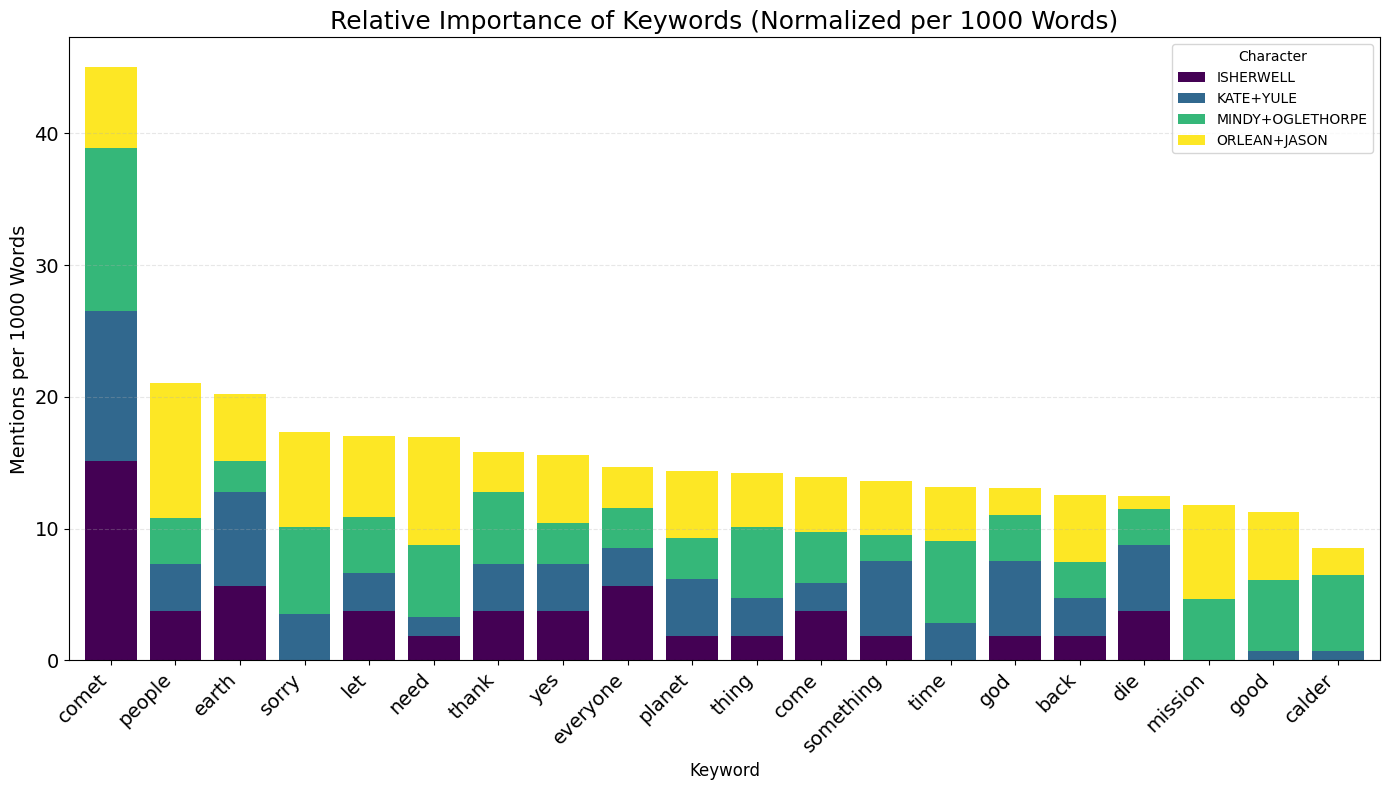

In [1]:

import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

# ==========================================
# 1. SETUP & CONFIG
# ==========================================
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Configuration of the names in the script
#CHAR_CONFIG = {
#    "MINDY": ["RANDALL", "DR. MINDY", "MINDY"],
#    "KATE": ["KATE", "KATE DIBIASKY"],
#    "ORLEAN": ["PRESIDENT ORLEAN", "ORLEAN", "JANIE"],
#    "ISHERWELL": ["PETER ISHERWELL", "PETER", "ISHERWELL"]
#}

CHAR_CONFIG = {
    "MINDY+OGLETHORPE": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "KATE+YULE": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "ORLEAN+JASON": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "ISHERWELL": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# ==========================================
# 2. FUNCTIONS (Parsing & Cleaning)
# ==========================================
def parse_screenplay_robust(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    data = []
    current_char = None
    current_buffer = []

    for line in lines:
        text = line.strip()
        if not text: continue

        # Neuer Sprecher?
        found_new_speaker = None
        for main_char, aliases in CHAR_CONFIG.items():
            for alias in aliases:
                if text.upper().startswith(alias) and len(text) < 30:
                    found_new_speaker = main_char
                    break
            if found_new_speaker: break
        
        if found_new_speaker:
            if current_char and current_buffer:
                data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})
            current_char = found_new_speaker
            current_buffer = []
        elif current_char:
            if text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT TO"):
                if current_buffer:
                    data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})
                current_char = None
                current_buffer = []
            elif not (text.startswith("(") and text.endswith(")")):
                current_buffer.append(text)

    if current_char and current_buffer:
        data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})

    return pd.DataFrame(data)

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    # Extended list of names and filler words to remove
    custom_ignore = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president",
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee",
        "jack", "bremmer", "june", "phillip", "yule", "adulrel", "dr", "teddy", 
        "goddard", "bash", "sir", "ma'am",
        "int", "ext", "cut", "continued", "cont'd", "day", "night", "vo", "os",
        "know", "going", "got", "yeah", "okay", "right", "look", "think", 
        "really", "well", "like", "say", "tell", "want", "gon", "one", "get", 
        "would", "could", "us", "see"
    ]
    stop_words.update(custom_ignore)
    tokens = nltk.word_tokenize(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) > 2 and w not in stop_words]

# ==========================================
# 3. MAIN PROGRAM (read & plot)
# ==========================================
file_path = 'Dont_Look_Up.txt' 

try:
    print("Read file...")
    df = parse_screenplay_robust(file_path)
    
    print(f"Found! {len(df)} Dialog blocks found.")
    print("Clear text...")
    df['Tokens'] = df['Dialogue'].apply(clean_text)

    # --- NORMALIZATION ---
    print("Calculate normalized frequencies...")

    # 1. Determine the total number of words per character
    char_totals = {}
    for char in CHAR_CONFIG.keys():
        all_char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
        char_totals[char] = len(all_char_tokens)
        print(f"   -> {char}: {char_totals[char]} Wörter total")

    # 2. Find global top 20 words
    all_tokens = [w for tokens in df['Tokens'] for w in tokens]
    total_counts = Counter(all_tokens)
    top_20_words_list = [word for word, count in total_counts.most_common(20)]
    
    print(f"   -> Top Themen: {top_20_words_list[:5]}...")

    # 3. Create Matrix (Normalized to 1000 words)
    matrix_data = []
    for char in CHAR_CONFIG.keys():
        char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
        char_dist = nltk.FreqDist(char_tokens)
        
        for word in top_20_words_list:
            raw_count = char_dist[word]
            total_words = char_totals[char]
            
            # Formula: (Count / Total) * 1000
            if total_words > 0:
                normalized_freq = (raw_count / total_words) * 1000
            else:
                normalized_freq = 0
                
            matrix_data.append({'Word': word, 'Character': char, 'Freq': normalized_freq})

    # 4. Plotting
    df_plot = pd.DataFrame(matrix_data)
    pivot_df = df_plot.pivot(index='Word', columns='Character', values='Freq')

    # Sort by importance
    pivot_df['Total_Weight'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values(by='Total_Weight', ascending=False)
    pivot_df = pivot_df.drop(columns=['Total_Weight'])

    # Create graphic
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, colormap='viridis')

    ax.tick_params(labelsize=14)
    plt.title("Relative Importance of Keywords (Normalized per 1000 Words)", fontsize=18)
    plt.ylabel("Mentions per 1000 Words", fontsize=14)
    plt.xlabel("Keyword", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Character')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: File '{file_path}' was not found.")

## Relative or normalized Word count of screenplay (Synonyms summarized eg earth, planet and globe => earth), Stack Bar Final, Figure 3: Shared vocabulary vs. divergent rhetoric

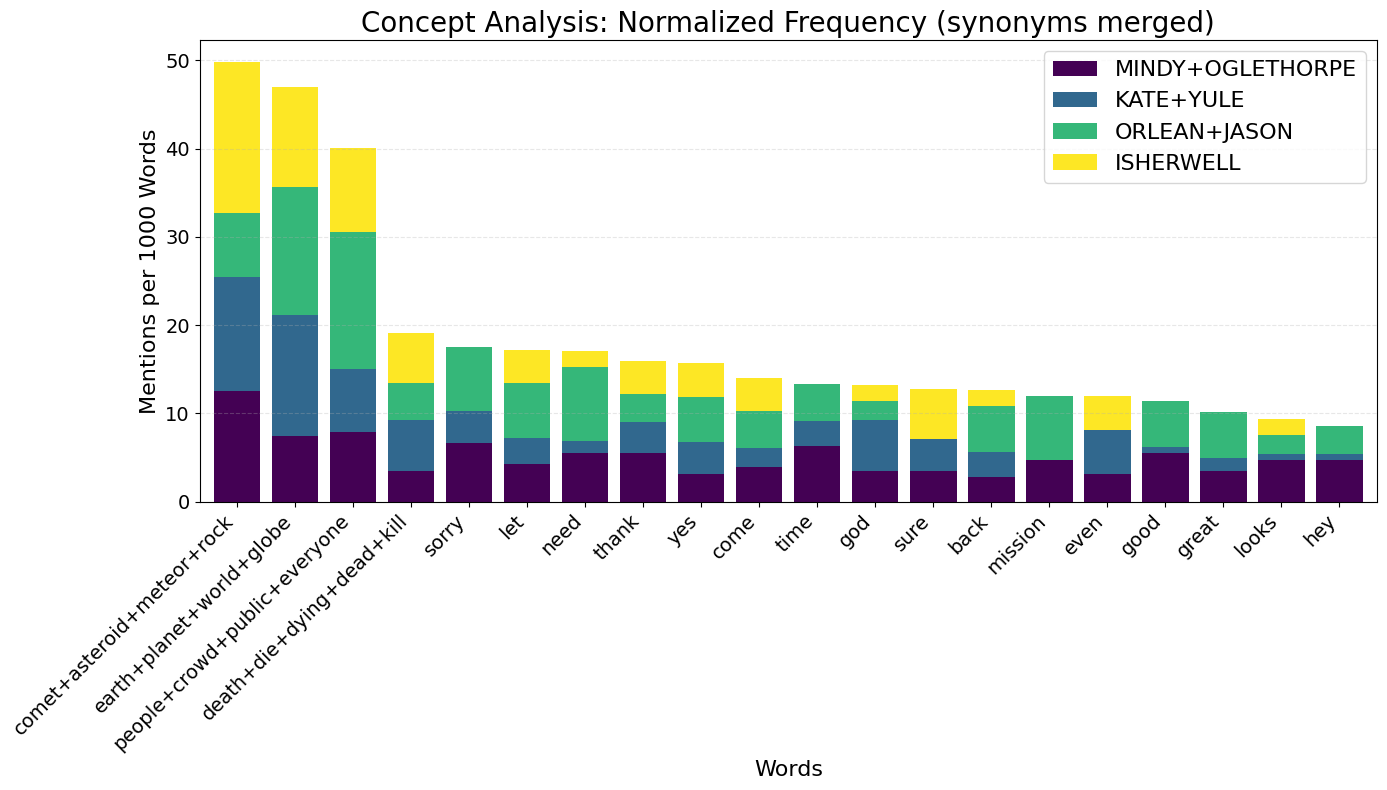

In [2]:
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

# ==========================================
# 1. SETUP & CONFIG
# ==========================================
# Make sure necessary NLTK data is there
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# The order here determines the order in the legend!
CHAR_CONFIG = {
    "MINDY+OGLETHORPE": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "KATE+YULE": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "ORLEAN+JASON": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "ISHERWELL": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# ==========================================
# 2. CLEANING WITH “CONCEPT MAPPING”
# ==========================================
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    
    # Deine Stopwords
    custom_ignore = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president",
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee",
        "jack", "bremmer", "june", "phillip", "yule", "adulrel", "dr", "teddy", 
        "goddard", "bash", "sir", "ma'am", "calder",
        "int", "ext", "cut", "continued", "cont'd", "day", "night", "vo", "os",
        "know", "going", "got", "yeah", "okay", "right", "look", "think", 
        "really", "well", "like", "say", "tell", "want", "gon", "one", "get", 
        "would", "could", "us", "see", "thing", "something"
    ]
    stop_words.update(custom_ignore)
    
    tokens = nltk.word_tokenize(text.lower())
    
    cleaned_tokens = []
    for w in tokens:
        if w.isalpha() and len(w) > 2 and w not in stop_words:
            
            # --- MAPPING: Simplify terms ---
            if w in ["earth","planet", "world", "globe"]:
                cleaned_tokens.append("earth+planet+world+globe") 
            
            elif w in ["money","dollar","dollars", "cash", "funds"]:
                cleaned_tokens.append("money+dollars+cash+funds")

            elif w in ["people","crowd","crowds","public", "everyone"]:
                cleaned_tokens.append("people+crowd+public+everyone")
            
            elif w in ["DIE","die","death", "died", "dying", "dead", "kill"]:
                cleaned_tokens.append("death+die+dying+dead+kill")
                
            #elif w in ["comet", "asteroid", "meteor", "rock", "object", "projectile"]:
            elif w in ["comet", "asteroid", "meteor", "rock", "object"]:
                cleaned_tokens.append("comet+asteroid+meteor+rock")                
                
            else:
                cleaned_tokens.append(w)
                
    return cleaned_tokens

# ==========================================
# 3. EXECUTION & PLOT
# ==========================================
file_path = 'Dont_Look_Up.txt' 

try:
    # --- Parsing ---
    if 'parse_screenplay_robust' not in locals():
         print("Please define the function 'parse_screenplay_robust()'!")
    else:
        df = parse_screenplay_robust(file_path) 
        df['Tokens'] = df['Dialogue'].apply(clean_text)

        # --- Calculate normalization basis ---
        char_totals = {}
        for char in CHAR_CONFIG.keys():
            all_char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
            char_totals[char] = len(all_char_tokens)

        # --- Find top 20 concepts ---
        all_tokens = [w for tokens in df['Tokens'] for w in tokens]
        total_counts = Counter(all_tokens)
        top_20_words_list = [word for word, count in total_counts.most_common(20)]
        
        # --- built matrix ---
        matrix_data = []
        for char in CHAR_CONFIG.keys():
            char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
            char_dist = nltk.FreqDist(char_tokens)
            
            for word in top_20_words_list:
                raw_count = char_dist[word]
                total_words = char_totals[char]
                # frequence of 1000 words
                normalized_freq = (raw_count / total_words) * 1000 if total_words > 0 else 0
                matrix_data.append({'Word': word, 'Character': char, 'Freq': normalized_freq})

        # --- Plot-prep ---
        df_plot = pd.DataFrame(matrix_data)
        pivot_df = df_plot.pivot(index='Word', columns='Character', values='Freq')

        # Force legend order (as defined in CHAR_CONFIG)
        desired_order = list(CHAR_CONFIG.keys()) 
        pivot_df = pivot_df.reindex(columns=desired_order)

        # Sorting the X-axis by total frequency
        pivot_df['Total_Weight'] = pivot_df.sum(axis=1)
        pivot_df = pivot_df.sort_values(by='Total_Weight', ascending=False)
        pivot_df = pivot_df.drop(columns=['Total_Weight'])

        # --- Plotting ---
        ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, colormap='viridis')
        
        plt.title("Concept Analysis: Normalized Frequency (synonyms merged)", fontsize=20)
        plt.ylabel("Mentions per 1000 Words", fontsize=16)
        plt.xlabel("Words", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        
        # Legend
        plt.legend(title='', loc='upper right', fontsize=16)

        ax.tick_params(labelsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig("Freq_Words.png", dpi=300, bbox_inches='tight')
        plt.show()

except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"Error occured: {e}")

## Data source summary - Distribution of Analyzed Text

--- DATA CHARACTERISTICS ---
                  Dialogue Blocks  Total Words (Cleaned)  \
Character                                                  
MINDY+OGLETHORPE              302                   2551   
KATE+YULE                     181                   1392   
ORLEAN+JASON                  132                    964   
ISHERWELL                      38                    528   

                  Avg. Words per Block  Share of Voice (%)  
Character                                                   
MINDY+OGLETHORPE                   8.4                46.9  
KATE+YULE                          7.7                25.6  
ORLEAN+JASON                       7.3                17.7  
ISHERWELL                         13.9                 9.7  


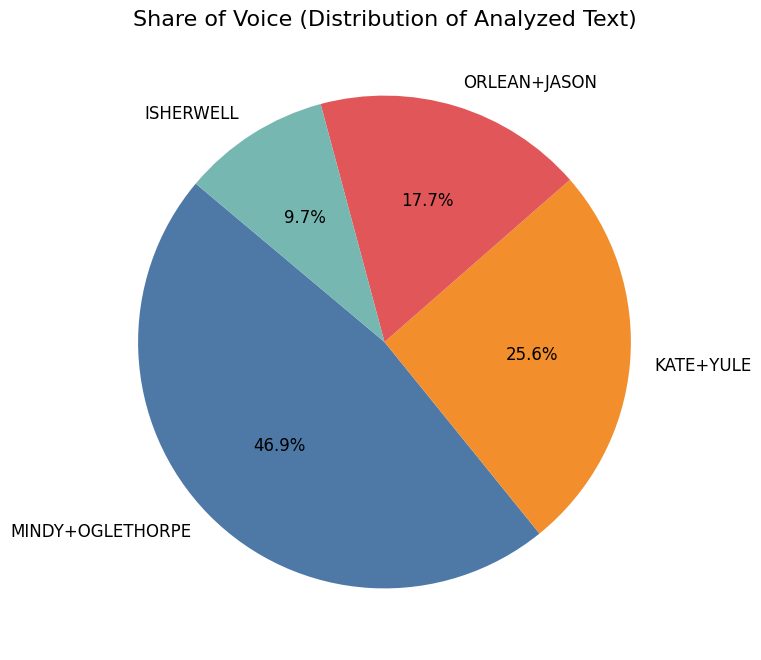

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# We assume that 'df' (the table with tokens) from the previous step is still there.
# If not, please run the big block from before ("parse_screenplay_robust") again.

try:
    print("--- DATA CHARACTERISTICS ---")
    
    stats_data = []
    
    for char in CHAR_CONFIG.keys():
        # Filter on the character
        char_df = df[df['Character'] == char]
        
        # 1. Number of speech acts (How often is he/she allowed to speak?)
        num_blocks = len(char_df)
        
        # 2. Collect all words (tokens) (How much does he/she say in total?)
        # Here we take the 'tokens' (cleaned up), you could also count raw words.
        all_tokens = [w for tokens in char_df['Tokens'] for w in tokens]
        num_words = len(all_tokens)
        
        # 3. Average length per speech act
        avg_len = round(num_words / num_blocks, 1) if num_blocks > 0 else 0
        
        stats_data.append({
            "Character": char,
            "Dialogue Blocks": num_blocks,
            "Total Words (Cleaned)": num_words,
            "Avg. Words per Block": avg_len
        })
    
    # Create table
    stats_df = pd.DataFrame(stats_data).set_index("Character")
    
    # Calculate percentage (Share of Voice)
    total_corpus_words = stats_df["Total Words (Cleaned)"].sum()
    stats_df["Share of Voice (%)"] = round((stats_df["Total Words (Cleaned)"] / total_corpus_words) * 100, 1)
    
    # Sort by word count
    stats_df = stats_df.sort_values(by="Total Words (Cleaned)", ascending=False)
    
    print(stats_df)
    
    # --- VISUALIZATION: CAKE DIAGRAM ---
    plt.figure(figsize=(8, 8))
   
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2'] 
    
    plt.pie(stats_df["Total Words (Cleaned)"], 
            labels=stats_df.index, 
            autopct='%1.1f%%', 
            startangle=140,
            colors=colors,
            textprops={'fontsize': 12})
            
    plt.title("Share of Voice (Distribution of Analyzed Text)", fontsize=16)
    plt.show()

except NameError:
    print("Error: The variable 'df' is missing. Please run the main code block from before first.")

# Distribution of all speakers - Number of Dialogue Blocks, Figure 2: shows the distribution of dialogues across the top 20 characters

Analyze entire speaker structure...
Total speaking roles found: 135

TOP 10 SPEAKERS (number of speeches):
                  Count
RANDALL             232
KATE                139
PRESIDENT ORLEAN     74
DR. OGLETHORPE       72
JASON                56
BRIE EVANTEE         51
PETER ISHERWELL      37
YULE                 33
JACK BREMMER         32
JUNE                 30


/tmp/ipykernel_604/102911163.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20['Count'], y=top_20.index, palette="viridis")


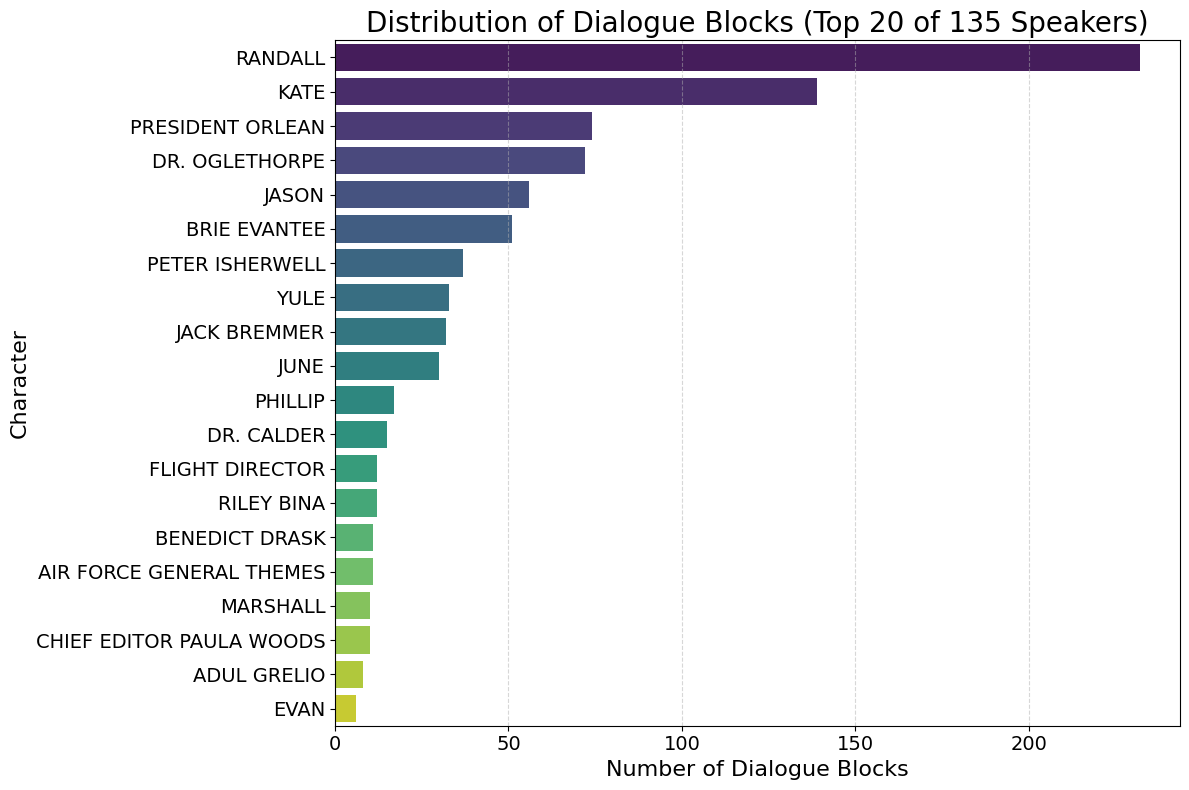

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# CUSTOMIZE FILE PATH
file_path = 'Dont_Look_Up.txt' 

def analyze_all_speakers(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    speaker_counts = Counter()
    
    # Exclude things that are capitalized in the script but are NOT spoken by
    blacklist = [
        "CUT TO", "FADE IN", "FADE OUT", "INT.", "EXT.", "THE END", 
        "CONTINUED", "OMITTED", "VOICE (OVER)", "TITLE", "CREDITS",
        "WRITTEN BY", "STORY BY", "DON'T LOOK UP", "BLACK.", "OPEN ON:",
        "JUMP CUT", "TIME JUMP"
    ]

    for line in lines:
        stripped = line.strip()
        
        # Criteria for a speaker name in the script:
        # 1. Not empty
        # 2. Completely CAPITALIZED (isupper)
        # 3. No numbers (no scene numbers like "12A")
        # 4. Not too long (scene descriptions are often long)
        if stripped and stripped.isupper() and len(stripped) < 35 and not any(char.isdigit() for char in stripped):
            
            # Cleaning: "MINDY (CONT'D)" -> "MINDY"
            # remove everything in parentheses
            clean_name = re.sub(r'\s*\(.*?\)', '', stripped).strip()
            
            # Cleanup: Punctuation removed (if "MINDY:" is there)
            clean_name = clean_name.replace(':', '')

            # Check against Blacklist
            is_valid = True
            for bad_word in blacklist:
                if bad_word in clean_name:
                    is_valid = False
                    break
            
            if is_valid and len(clean_name) > 1: # Ignore single-letter names
                speaker_counts[clean_name] += 1

    return speaker_counts

# --- EXECUTION ---
try:
    print("Analyze entire speaker structure...")
    counts = analyze_all_speakers(file_path)
    
    # Create DataFrame
    df_speakers = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
    df_speakers = df_speakers.sort_values(by='Count', ascending=False)
    
    print(f"Total speaking roles found: {len(df_speakers)}")
    print("\nTOP 10 SPEAKERS (number of speeches):")
    print(df_speakers.head(10))

    # --- VISUALIZATION (TOP 20) ---
    plt.figure(figsize=(12, 8))
    
    # Only plot the top 20
    top_20 = df_speakers.head(20)
    
    sns.barplot(x=top_20['Count'], y=top_20.index, palette="viridis")
    
    plt.title(f"Distribution of Dialogue Blocks (Top 20 of {len(df_speakers)} Speakers)", fontsize=20)
    plt.xlabel("Number of Dialogue Blocks", fontsize=16)
    plt.ylabel("Character", fontsize=16)
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("Freq_Speaker.png", dpi=300, bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print("File not found.")

## Additional keyword generation (TF-IDF)

In [15]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# NLTK Setup
nltk.download('stopwords')
nltk.download('punkt')

# 1. SETUP: Grouping
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Panic/Truth)": ["KATE", "KATE DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# Source file
file_path = 'Dont_Look_Up.txt' 

# 2. PARSING (text grouping)
def get_grouped_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    group_texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    current_group = None
    
    # Mapping for fas search
    alias_map = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_map[alias] = group

    for line in lines:
        text = line.strip()
        if not text: continue
        
        # Recognizing speaker changes
        found = None
        for alias, group in alias_map.items():
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found = group
                break
        
        if found:
            current_group = found
        elif current_group:
            # Collect text (without stage directions)
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                group_texts[current_group].append(text)
    
    return {k: " ".join(v) for k, v in group_texts.items()}

# 3. ANALYSE (TF-IDF)
def extract_distinctive_keywords(grouped_data):
    # Custom stopwords (remove character names so that "Randall" doesn't become a keyword for Science
    base_stopwords = stopwords.words('english')
    custom_stopwords = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president", "bremmer", "phillip", "june", "jack", "calder", "really", "ok",  "want", "tell", "riley",
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee", "teddy", 'benedict', 'marshall', 'linda', 'diddly', 'guys', 'see', 'put',
        "dr", "yeah", "okay", "right", "know", "going", "think", "look", "get", 'harrison', 'must', 'could', 'ms', 'trying', 'dj', 'sons',
        "got", "gonna", "well", "like", "one", "guy", "man", "sir", "ma'am"
    ]
    all_stops = list(base_stopwords) + custom_stopwords

    # TF-IDF Vectorizer
    # max_df=0.75 This means that words that appear in more than 75% of the groups (i.e., everywhere) are ignored.
    # This guarantees the "disjointness" (discrimination).
    tfidf = TfidfVectorizer(stop_words=all_stops, max_df=0.75, max_features=1000)
    
    # Create matrix
    groups = list(grouped_data.keys())
    texts = list(grouped_data.values())
    tfidf_matrix = tfidf.fit_transform(texts)
    
    feature_names = tfidf.get_feature_names_out()
    
    print("\n--- AUTOMATICALLY GENERATED DISTINCTIVE KEYWORDS ---")
    print("(Words that are particularly typical for this group)\n")

    suggested_keywords = {}

    for i, group in enumerate(groups):
        # Get the row for the current group
        row = tfidf_matrix[i].toarray().flatten()
        # Sortieren nach Score (höchster zuerst)
        top_indices = row.argsort()[-30:][::-1] # Top 30
        
        top_words = [feature_names[ind] for ind in top_indices]
        suggested_keywords[group] = top_words
        
        print(f"Group: {group}")
        print(f"Top Keywords: {top_words}")
        print("-" * 40)

    return suggested_keywords

# --- EXECUTION ---
try:
    data = get_grouped_text(file_path)
    extract_distinctive_keywords(data)
except FileNotFoundError:
    print("File not found.")


--- AUTOMATICALLY GENERATED DISTINCTIVE KEYWORDS ---
(Words that are particularly typical for this group)

Group: SCIENCE (Rationality)
Top Keywords: ['sorry', 'mission', 'time', 'general', 'good', 'bina', 'gets', 'media', 'themes', 'hey', 'chello', 'air', 'way', '10', 'even', 'force', 'crowd', 'long', 'space', 'house', 'listen', 'across', 'xanax', 'fucking', 'great', 'nasa', 'beat', 'hand', 'dad', 'um']
----------------------------------------
Group: ACTIVISM (Panic/Truth)
Top Keywords: ['office', 'shit', 'house', 'fuck', 'free', 'talk', 'open', 'general', 'mean', 'beat', 'car', 'even', 'air', 'board', 'hair', 'force', 'around', 'white', 'light', 'love', 'directly', 'suddenly', 'conlon', 'sheriff', 'star', 'coffee', 'diet', 'plays', 'dad', 'oval']
----------------------------------------
Group: POPULISM (Image)
Top Keywords: ['mission', 'drask', 'crowd', 'smoke', 'turning', 'sorry', 'around', 'still', 'seriously', 'raghav', 'cigarette', 'emergency', 'presidential', 'coordinator', 'he

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Word Cloud - Figure 4: The Texture of Divergence

Re-read file: Dont_Look_Up.txt ...

--- STATUS CHECK ---
SCIENCE (Rationality): 54042 characters found.
ACTIVISM (Truth/Panic): 27208 characters found.
POPULISM (Image): 20918 characters found.
CAPITALISM (Profit): 8050 characters found.
Activism has text!


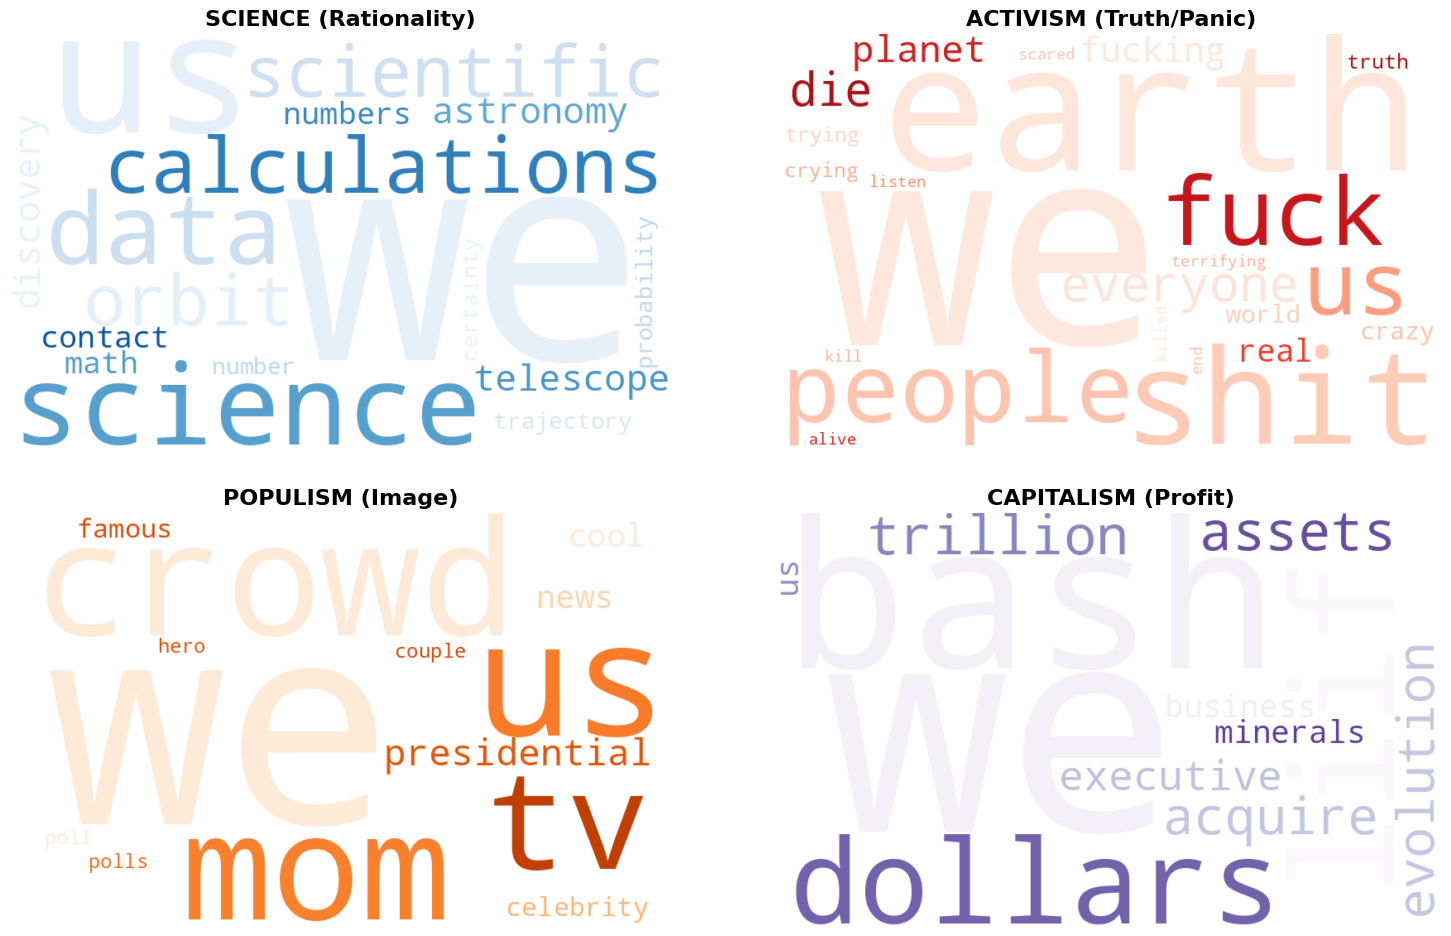

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud

# ==========================================
# 1. SETUP: DEFINING GROUPS & KEYWORDS
# ==========================================
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Truth/Panic)": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculation", "calculations", 
        "accuracy", "fact", "facts", "physics", "sigma", "astronomy", 
        "discovery", "object", "orbit", "probability", "contact", "certainty", "we", "us"
    ],
    "ACTIVISM (Truth/Panic)": [
        "truth", "die", "dying", "kill", "killed", "planet", "earth", "world",
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "listen", "crying", "crazy",
        "people", "everyone", "trying", "joke", "nuts", "insane", "we", "us"
    ],
    "POPULISM (Image)": [
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous", "cool", "love", "couple", "we", "us"
    ],
    "CAPITALISM (Profit)": [
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold", "job", "jobs",
        "business", "economy", "rights", "we", "us"
    ]
}

COLOR_MAPS = {
    "SCIENCE (Rationality)": "Blues",
    "ACTIVISM (Truth/Panic)": "Reds",
    "POPULISM (Image)": "Oranges",
    "CAPITALISM (Profit)": "Purples"
}

# ==========================================
# 2. NEW PARSING (Force reading!)
# ==========================================
file_path = 'Dont_Look_Up.txt' 

def force_reparse(path):
    print(f"Re-read file: {path} ...")
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Create empty containers
    texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    
    # Build an alias map
    alias_map = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_map[alias] = group

    current_group = None

    for line in lines:
        text = line.strip()
        if not text: continue
        
        # Check: Is it a name?
        found_group = None
        for alias, group in alias_map.items():
            # Precise start check
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found_group = group
                break
        
        if found_group:
            current_group = found_group
        elif current_group:
            # Collect text (without stage directions)
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                 texts[current_group].append(text)
    
    return {k: " ".join(v) for k, v in texts.items()}

# reload and parse file
grouped_text = force_reparse(file_path)

print("\n--- STATUS CHECK ---")
for group, content in grouped_text.items():
    print(f"{group}: {len(content)} characters found.")
    
if len(grouped_text["ACTIVISM (Truth/Panic)"]) < 100:
    print("Activism is still empty!")
else:
    print("Activism has text!")

# ==========================================
# 3. PLOTTING
# ==========================================
def count_exact_keywords_robust(text, target_keywords):
    text_lower = text.lower()
    tokens = re.findall(r"\b\w+\b", text_lower)
    counts = {k: 0 for k in target_keywords}
    for t in tokens:
        if t in target_keywords:
            counts[t] += 1
    return {k: v for k, v in counts.items() if v > 0}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, (group_name, text) in enumerate(grouped_text.items()):
    ax = axes[i]
    colormap = COLOR_MAPS.get(group_name, "Greys")
    target_keys = KEYWORDS.get(group_name, [])
    
    # Zählen
    frequencies = count_exact_keywords_robust(text, target_keys)
    
    if frequencies:
        wc = WordCloud(
            background_color="white",
            width=800, height=500,
            colormap=colormap,
            random_state=42,
            max_words=50,
            prefer_horizontal=0.9
        ).generate_from_frequencies(frequencies)
        
        image_array = np.array(wc.to_image())
        ax.imshow(image_array, interpolation="bilinear")
    else:
        ax.text(0.5, 0.5, "LEER", ha='center', va='center', fontsize=20, color='red')
    
    ax.set_title(group_name, fontsize=16, fontweight="bold")
    ax.axis("off")
    
    # Rahmen
    cmap = plt.get_cmap(colormap)
    spine_color = cmap(0.9) 
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(spine_color)
        spine.set_linewidth(2)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)
plt.savefig("Cloud.png", dpi=300, bbox_inches='tight')
plt.show()

# Heatmap (cosine similarity) and Radar Chart -(Figure 5+6 in final work)

Lade Sprachmodell (das kann kurz dauern)...
Lese Datei: Dont_Look_Up.txt ...
Calculate semantic distance (via scikit-learn)...
Scanne Text nach Keywords...

--- COSINUS SIMILARITY (Ideological Distance) ---
                        SCIENCE (Rationality)  ACTIVISM (Truth/Panic)  \
SCIENCE (Rationality)                1.000000                0.396361   
ACTIVISM (Truth/Panic)               0.396361                1.000000   
POPULISM (Image)                     0.505560                0.644108   
CAPITALISM (Profit)                  0.630820                0.422815   

                        POPULISM (Image)  CAPITALISM (Profit)  
SCIENCE (Rationality)           0.505560             0.630820  
ACTIVISM (Truth/Panic)          0.644108             0.422815  
POPULISM (Image)                1.000000             0.532757  
CAPITALISM (Profit)             0.532757             1.000000  


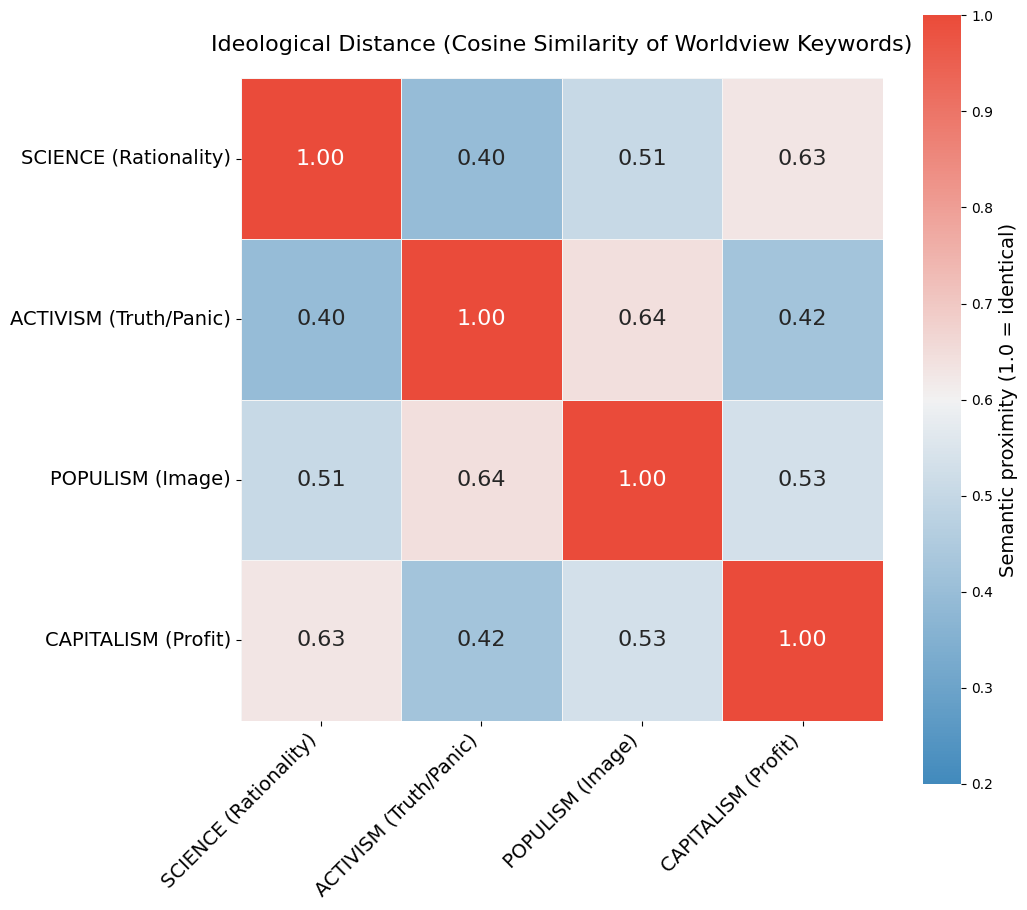

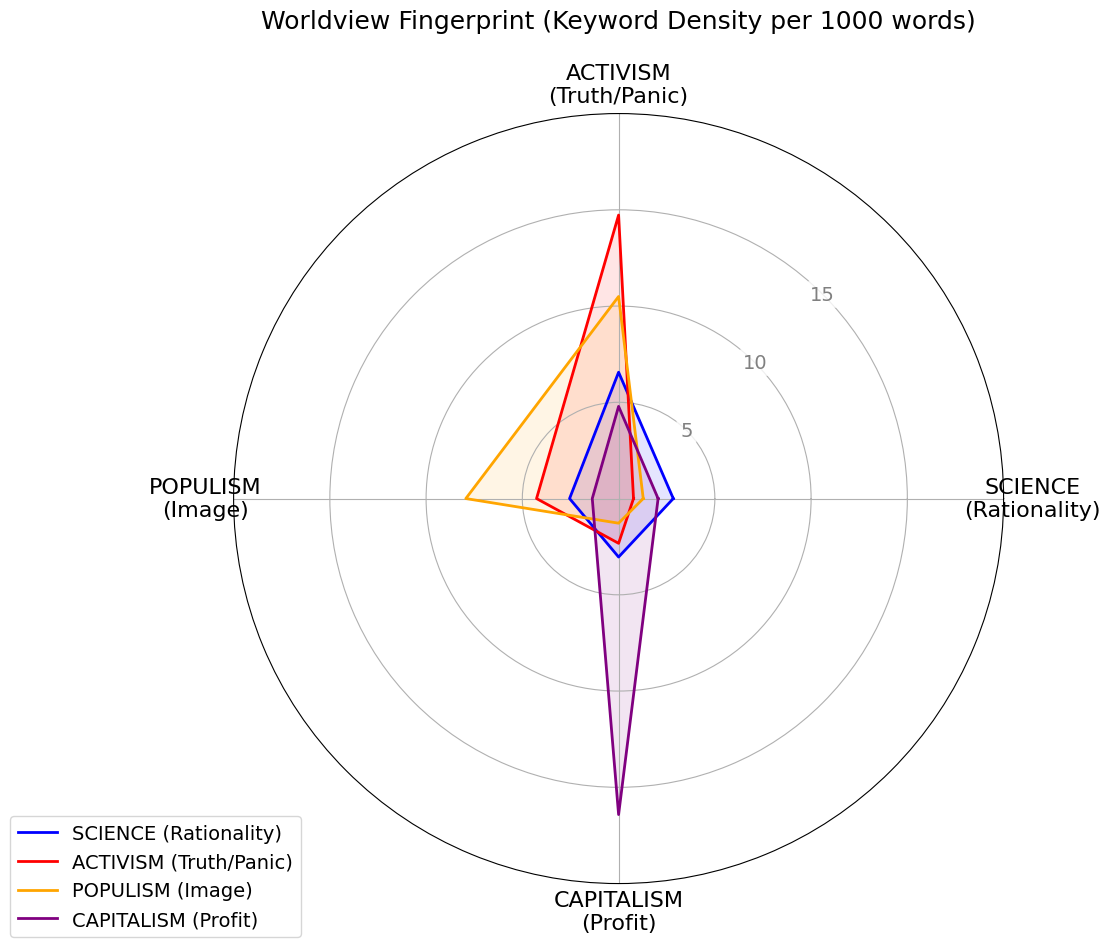

In [17]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from math import pi
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================
# 1. SETUP & MODEL LOADING
# ==========================================
print("Lade Sprachmodell (das kann kurz dauern)...")
try:
    # Medium model for vectors (md)
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("FEHLER: Bitte lade das Modell erst herunter:")
    print("Run: python -m spacy download en_core_web_md")
    exit()

# DEFINITION OF THE 4 WORLDVIEW GROUPS
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Truth/Panic)": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# KEYWORDS 
KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculations", "accuracy", 
        "fact", "facts", "physics", "sigma", "orbit", "probability", "certainty"
    ],
    "ACTIVISM (Truth/Panic)": [
        "truth", "die", "dying", "kill", "killed", "planet", "earth", 
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "crying", "insane"
    ],
    "POPULISM (Image)": [
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous"
    ],
    "CAPITALISM (Profit)": [
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold"
    ]
}

# ==========================================
# 2. DATA PARSING
# ==========================================
def parse_screenplay_grouped(file_path):
    print(f"Lese Datei: {file_path} ...")
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    group_texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    current_group = None
    
    alias_to_group = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_to_group[alias] = group

    for line in lines:
        text = line.strip()
        if not text: continue

        found_group = None
        for alias, group in alias_to_group.items():
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found_group = group
                break
        
        if found_group:
            current_group = found_group
        elif current_group:
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                 group_texts[current_group].append(text)

    return {k: " ".join(v) for k, v in group_texts.items()}

# ==========================================
# 3. ANALYSIS (Concept Similarity)
# ==========================================
def analyze_worldviews(text_data):
    results_keywords = {}
    
    # --- PART A: COSINUS-SIMILITANCE OF IDEOLOGY ---

    print("Calculate semantic distance (via scikit-learn)...")
    
    groups = list(KEYWORDS.keys())
    sim_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    # Creating vectors
    vectors = []
    for group in groups:
        word_list = KEYWORDS[group]
        concept_text = " ".join(word_list)
        # .vector gibt uns das reine NumPy-Array zurück
        # .reshape(1, -1) ist nötig, weil sklearn 2D-Arrays erwartet
        vec = nlp(concept_text).vector.reshape(1, -1)
        vectors.append(vec)
    
    # Fill matrix with sclearn
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            # Hier nutzen wir jetzt explizit sklearn
            sim = cosine_similarity(vectors[i], vectors[j])[0][0]
            sim_matrix.loc[g1, g2] = sim

    # --- PART B: DENSITY SCAN ---
    print("Scanne Text nach Keywords...")
    docs = {}
    for group, text in text_data.items():
        if len(text) == 0: continue
        docs[group] = nlp(text[:200000]) 

    for group, doc in docs.items():
        counts = {k: 0 for k in KEYWORDS.keys()}
        
        # More robust tokenization (no punctuation)
        tokens = [t.lemma_.lower() for t in doc if not t.is_punct and not t.is_space]
        total_words = len(tokens)
        
        if total_words == 0: continue

        for t in tokens:
            for category, word_list in KEYWORDS.items():
                if t in word_list:
                    counts[category] += 1
        
        results_keywords[group] = {k: (v / total_words) * 1000 for k, v in counts.items()}

    return sim_matrix, results_keywords

# ==========================================
# 4. VISUALIZATION
# ==========================================
def plot_results(sim_matrix, keyword_data):
    
    # --- PLOT 1: HEATMAP (Ideological Distance) ---
    plt.figure(figsize=(10, 9)) # Etwas höher für die Labels
    
    # as_cmap=True creates a continuous color scale
    custom_cmap = sns.diverging_palette(240, 15, s=80, l=55, n=9, as_cmap=True, center="light")

    ax = sns.heatmap(
        sim_matrix, 
        annot=True, 
        cmap=custom_cmap,  
        vmin=0.2, vmax=1.0,   
        fmt=".2f",
        square=True,           
        linewidths=.5,        
        linecolor='whitesmoke',
        annot_kws={"size": 16}, 
        cbar_kws={'label': 'Semantic proximity (1.0 = identical)'}  
    )
    
    plt.title("Ideological Distance (Cosine Similarity of Worldview Keywords)", fontsize=16, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    ax.tick_params(labelsize=14)
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(14)
    plt.savefig("Heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- PLOT 2: RADAR CHART (The Worldview) ---
    
    # 1. prepare data
    original_labels = list(KEYWORDS.keys())
    display_labels = [label.replace(" (", "\n(") for label in original_labels]
    num_vars = len(original_labels)
    
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] 
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    # 1. X-axis
    plt.xticks(angles[:-1], display_labels, color='black', size=16)
    ax.tick_params(axis='x', pad=10)

    # 2. Y-axis: Turn off default labeling
    plt.yticks([5, 10, 15], labels=[], color="grey") # labels=[] empties text
    plt.ylim(0, 20)

    # 3. Y-axis: Set numbers manually
    label_angle_deg = 45
    label_angle_rad = np.deg2rad(label_angle_deg) 

    # Loop to manually write the numbers 5, 10, 15
    for val in [5, 10, 15]:
        ax.text(
            label_angle_rad,  # Angle (X-Pos)
            val,              # Radius (Y-Pos)
            str(val),         # Text
            color="grey",
            size=14,
            ha='center',      
            va='center',      
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8)
        )

    # --- data plotting ---
    colors = ['blue', 'red', 'orange', 'purple']

    if not keyword_data:
        print("No keyword data found for plotting.")
    else:
        for i, (group, data) in enumerate(keyword_data.items()):
            values = [data.get(l, 0) for l in original_labels]
            values += values[:1] 
        
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=group, color=colors[i])
            ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Worldview Fingerprint (Keyword Density per 1000 words)", size=18, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)
    #plt.legend(title='', loc='upper right', fontsize=16)

    plt.savefig("Chart.png", dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================
file_path = 'Dont_Look_Up.txt' 

try:
    grouped_text = parse_screenplay_grouped(file_path)
    sim_matrix, keyword_results = analyze_worldviews(grouped_text)
    
    print("\n--- COSINUS SIMILARITY (Ideological Distance) ---")
    print(sim_matrix)
    
    # call plot_results 
    plot_results(sim_matrix, keyword_results)

except FileNotFoundError:
    print(f"File not found: {file_path}")